In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [29]:
df = pd.read_csv('workforce_sales_prediction_dataset_with_target.csv')
df

,Employee_Performance,Heart_Rate,Steps_Taken,Fatigue_Level,Temperature,Humidity,Noise_Level,Target
0,68.727006,88.709652,13664,5.464071,24.116713,33.523034,47.616163,Low
1,97.535715,73.896142,10219,2.497442,21.600805,43.907182,96.016923,High
2,86.599697,61.317073,9080,3.432755,19.815171,46.225332,92.041278,High
3,79.932924,75.346291,3985,8.520484,21.416097,77.256122,54.016542,High
4,57.800932,43.642523,14345,5.592181,22.511655,44.133368,86.702314,Medium
...,...,...,...,...,...,...,...,...
995,54.579104,84.665409,2545,1.136460,19.469777,61.445257,68.070951,Low
996,95.865679,58.884198,3927,0.039184,24.408433,35.896934,79.446660,High
997,56.840932,69.641744,6152,9.994607,28.553552,62.747055,93.704003,Low
998,97.511868,64.685454,2004,8.022737,22.920285,44.164826,63.577046,Medium


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee_Performance  1000 non-null   float64
 1   Heart_Rate            1000 non-null   float64
 2   Steps_Taken           1000 non-null   int64  
 3   Fatigue_Level         1000 non-null   float64
 4   Temperature           1000 non-null   float64
 5   Humidity              1000 non-null   float64
 6   Noise_Level           1000 non-null   float64
 7   Target                1000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 62.6+ KB


In [4]:
# Cek nilai kosong
df.isnull().sum()

Employee_Performance    0
Heart_Rate              0
Steps_Taken             0
Fatigue_Level           0
Temperature             0
Humidity                0
Noise_Level             0
Target                  0
dtype: int64

In [5]:
df.describe()

,Employee_Performance,Heart_Rate,Steps_Taken,Fatigue_Level,Temperature,Humidity,Noise_Level
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,74.512828,70.023583,8262.901000,5.005327,23.899545,54.244368,69.204752
std,14.606868,10.231786,3734.990752,2.905493,3.471032,14.212894,16.899494
min,50.231601,40.088640,2001.000000,0.039184,18.002892,30.012147,40.024617
25%,61.798663,62.929241,5017.500000,2.471784,20.887148,42.103936,55.131838
50%,74.840369,69.986412,8245.000000,4.921844,23.815716,54.119495,68.566689
75%,87.215979,76.815370,11371.500000,7.551687,27.009629,65.755404,83.130545
max,99.985884,109.262377,14995.000000,9.994607,29.990488,79.945235,99.819430


In [6]:
from sklearn.preprocessing import StandardScaler

# Menentukan fitur-fitur yang digunakan sebagai input Gaussian Mixture Model (GMM).
# Fitur dipilih berdasarkan indikator fisiologis (Heart_Rate, Fatigue_Level),
# aktivitas fisik (Steps_Taken), serta faktor lingkungan kerja (Temperature, Noise_Level)
# yang diduga berpengaruh terhadap tingkat kantuk karyawan.
gmm_features = [
    'Heart_Rate',
    'Steps_Taken',
    'Fatigue_Level',
    'Temperature',
    'Noise_Level'
]

# Mengambil subset data hanya pada fitur yang relevan untuk proses clustering
X_gmm = df[gmm_features]

# Melakukan standardisasi fitur menggunakan StandardScaler.
# Proses ini mengubah setiap fitur agar memiliki mean = 0 dan standar deviasi = 1,
X_scaled = StandardScaler().fit_transform(X_gmm)

# X_scaled merupakan data hasil normalisasi yang siap digunakan
# sebagai input pada Gaussian Mixture Model
X_scaled

array([[ 1.82719024,  1.44680454,  0.15796752,  0.0625972 , -1.27810869],
       [ 0.37867259,  0.52398464, -0.86358485, -0.66259552,  1.58736034],
       [-0.85135349,  0.21887815, -0.54151177, -1.17729181,  1.35199036],
       ...,
       [-0.03733753, -0.5654518 ,  1.71804799,  1.34148488,  1.45042863],
       [-0.52198115, -1.67658589,  1.0390388 , -0.28226458, -0.33317694],
       [-1.53541467,  1.44921539,  0.98549036, -0.03332253,  1.68734387]],
      shape=(1000, 5))

In [7]:
from sklearn.mixture import GaussianMixture

# Menginisialisasi Gaussian Mixture Model (GMM) dengan 2 komponen (cluster).
# Dua cluster diasumsikan merepresentasikan dua kondisi fisiologis utama,
# yaitu kondisi waspada (tidak kantuk) dan kondisi kantuk.
# Parameter random_state digunakan agar hasil clustering konsisten setiap kali proses dijalankan.
gmm = GaussianMixture(n_components=2, random_state=42)

# Melakukan proses fitting GMM pada data fitur yang telah dinormalisasi,
# kemudian menetapkan label cluster untuk setiap data.
# Label yang dihasilkan bersifat unsupervised (pseudo-label),
# sehingga merepresentasikan kelompok kondisi fisiologis,
# bukan label kantuk klinis atau ground truth.
df['label'] = gmm.fit_predict(X_scaled)
df

,Employee_Performance,Heart_Rate,Steps_Taken,Fatigue_Level,Temperature,Humidity,Noise_Level,Target,label
0,68.727006,88.709652,13664,5.464071,24.116713,33.523034,47.616163,Low,0
1,97.535715,73.896142,10219,2.497442,21.600805,43.907182,96.016923,High,0
2,86.599697,61.317073,9080,3.432755,19.815171,46.225332,92.041278,High,0
3,79.932924,75.346291,3985,8.520484,21.416097,77.256122,54.016542,High,0
4,57.800932,43.642523,14345,5.592181,22.511655,44.133368,86.702314,Medium,0
...,...,...,...,...,...,...,...,...,...
995,54.579104,84.665409,2545,1.136460,19.469777,61.445257,68.070951,Low,0
996,95.865679,58.884198,3927,0.039184,24.408433,35.896934,79.446660,High,1
997,56.840932,69.641744,6152,9.994607,28.553552,62.747055,93.704003,Low,1
998,97.511868,64.685454,2004,8.022737,22.920285,44.164826,63.577046,Medium,0


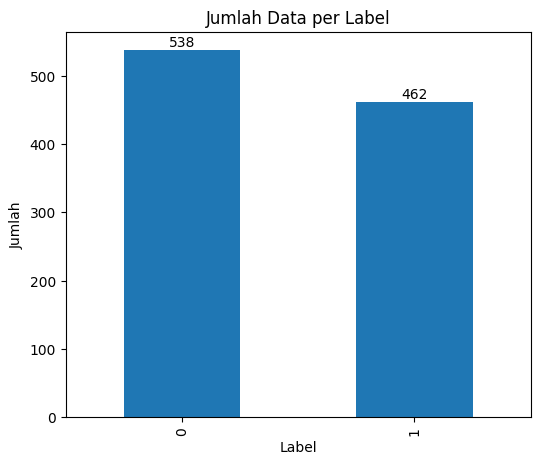

In [8]:
# Hitung jumlah per label
counts = df.label.value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(6,5))
counts.plot(kind='bar')

# Tambahkan judul dan label sumbu
plt.title('Jumlah Data per Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')

# Tambahkan nilai pada setiap batang
for i, v in enumerate(counts):
    plt.text(i, v + (0.01 * v), str(v), ha='center')

plt.show()

## Feature Engineering

In [9]:
df_select = df[['Heart_Rate', 'Steps_Taken', 'Temperature', 'label']]
df_select

,Heart_Rate,Steps_Taken,Temperature,label
0,88.709652,13664,24.116713,0
1,73.896142,10219,21.600805,0
2,61.317073,9080,19.815171,0
3,75.346291,3985,21.416097,0
4,43.642523,14345,22.511655,0
...,...,...,...,...
995,84.665409,2545,19.469777,0
996,58.884198,3927,24.408433,1
997,69.641744,6152,28.553552,1
998,64.685454,2004,22.920285,0


In [10]:
df_final = df_select.copy()

# Menentukan ukuran window untuk perhitungan rolling statistics.
# Window = 10 berarti setiap nilai fitur baru dihitung berdasarkan 10 data berturut-turut sebelumnya.
window = 10

# Menghitung nilai rata-rata (mean) heart rate menggunakan rolling window.
# Fitur ini digunakan untuk menangkap tren detak jantung jangka pendek dan mengurangi noise pada sinyal heart rate mentah.
df_final['HR_mean'] = df_final['Heart_Rate'].rolling(window=window).mean()

# Menghitung standar deviasi (std) heart rate menggunakan rolling window.
# Fitur ini merepresentasikan tingkat fluktuasi detak jantung, yang dapat mengindikasikan perubahan kondisi fisiologis.
df_final['HR_std'] = df_final['Heart_Rate'].rolling(window=window).std()

# Menghitung nilai rata-rata suhu lingkungan menggunakan rolling window untuk menangkap tren perubahan suhu secara lokal.
df_final['Temp_mean'] = df_final['Temperature'].rolling(window=window).mean()

# Menghitung standar deviasi suhu lingkungan menggunakan rolling window untuk merepresentasikan kestabilan atau variasi suhu lingkungan.
df_final['Temp_std'] = df_final['Temperature'].rolling(window=window).std()

# Mengisi nilai NaN yang muncul akibat proses rolling (pada baris awal data) menggunakan metode backward fill (bfill).
# Pendekatan ini memastikan tidak ada data kosong sebelum proses analisis.
df_final = df_final.bfill()
df_final

,Heart_Rate,Steps_Taken,Temperature,label,HR_mean,HR_std,Temp_mean,Temp_std
0,88.709652,13664,24.116713,0,69.618426,12.302555,21.738624,2.841210
1,73.896142,10219,21.600805,0,69.618426,12.302555,21.738624,2.841210
2,61.317073,9080,19.815171,0,69.618426,12.302555,21.738624,2.841210
3,75.346291,3985,21.416097,0,69.618426,12.302555,21.738624,2.841210
4,43.642523,14345,22.511655,0,69.618426,12.302555,21.738624,2.841210
...,...,...,...,...,...,...,...,...
995,84.665409,2545,19.469777,0,75.217740,8.212603,24.226966,3.792544
996,58.884198,3927,24.408433,1,74.155189,9.602861,24.378161,3.763637
997,69.641744,6152,28.553552,1,74.279723,9.527660,25.203984,3.673164
998,64.685454,2004,22.920285,0,73.417417,10.003654,25.075471,3.733961


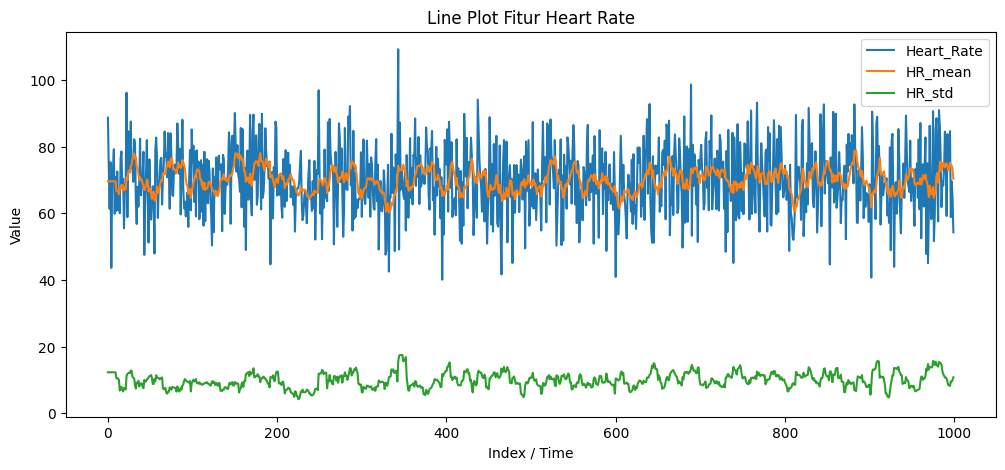

In [11]:
features_hr = ['Heart_Rate', 'HR_mean', 'HR_std']

plt.figure(figsize=(12, 5))
for col in features_hr:
    plt.plot(df_final[col], label=col)

plt.legend()
plt.xlabel("Index / Time")
plt.ylabel("Value")
plt.title("Line Plot Fitur Heart Rate")
plt.show()

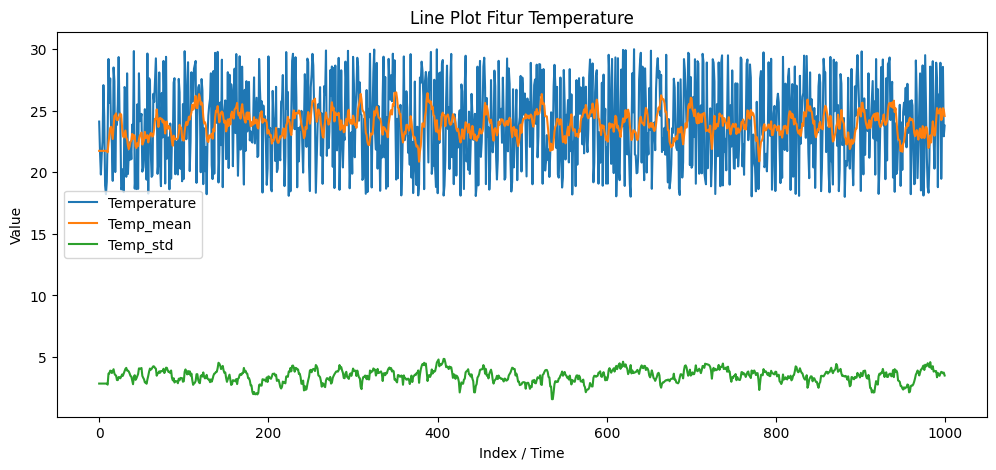

In [12]:
features_temp = ['Temperature', 'Temp_mean', 'Temp_std']

plt.figure(figsize=(12, 5))
for col in features_temp:
    plt.plot(df_final[col], label=col)

plt.legend()
plt.xlabel("Index / Time")
plt.ylabel("Value")
plt.title("Line Plot Fitur Temperature")
plt.show()

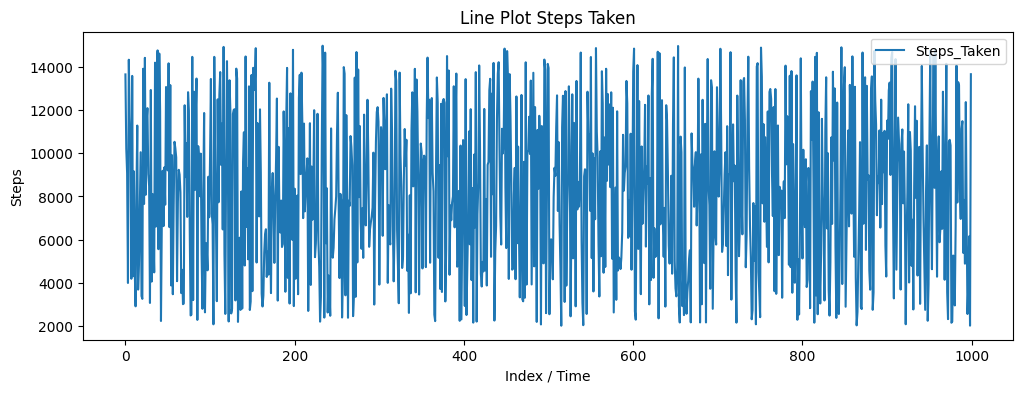

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(df_final['Steps_Taken'], label='Steps_Taken')

plt.legend()
plt.xlabel("Index / Time")
plt.ylabel("Steps")
plt.title("Line Plot Steps Taken")
plt.show()

In [14]:
df_final.corr()['label']

Heart_Rate    -0.034964
Steps_Taken    0.081512
Temperature    0.852824
label          1.000000
HR_mean       -0.000766
HR_std         0.015254
Temp_mean      0.250947
Temp_std       0.023755
Name: label, dtype: float64

In [15]:
# Memisahkan data menjadi fitur (X) dan target (y).
# X berisi seluruh fitur hasil preprocessing dan feature engineering,
# sedangkan kolom 'label' dijadikan sebagai target.
X = df_final.drop(columns=['label'])
y = df_final['label']

In [16]:
X

,Heart_Rate,Steps_Taken,Temperature,HR_mean,HR_std,Temp_mean,Temp_std
0,88.709652,13664,24.116713,69.618426,12.302555,21.738624,2.841210
1,73.896142,10219,21.600805,69.618426,12.302555,21.738624,2.841210
2,61.317073,9080,19.815171,69.618426,12.302555,21.738624,2.841210
3,75.346291,3985,21.416097,69.618426,12.302555,21.738624,2.841210
4,43.642523,14345,22.511655,69.618426,12.302555,21.738624,2.841210
...,...,...,...,...,...,...,...
995,84.665409,2545,19.469777,75.217740,8.212603,24.226966,3.792544
996,58.884198,3927,24.408433,74.155189,9.602861,24.378161,3.763637
997,69.641744,6152,28.553552,74.279723,9.527660,25.203984,3.673164
998,64.685454,2004,22.920285,73.417417,10.003654,25.075471,3.733961


In [17]:
y

0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    1
997    1
998    0
999    1
Name: label, Length: 1000, dtype: int64

## Split Data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

print(f'Jumlah Data Training: {X_train.shape[0]}')
print(f'Jumlah Data Testing : {X_test.shape[0]}')

Jumlah Data Training: 900
Jumlah Data Testing : 100


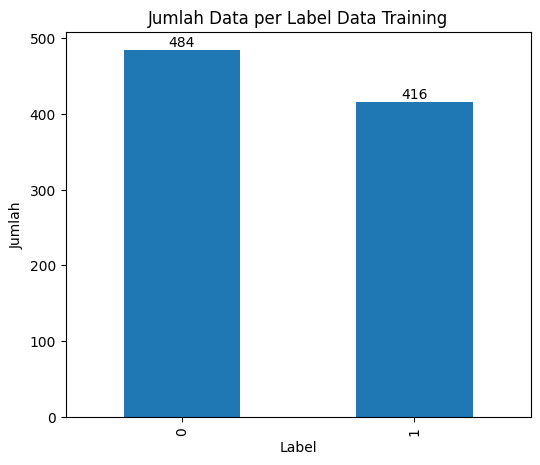

In [19]:
# Hitung jumlah per label
counts = y_train.value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(6,5))
counts.plot(kind='bar')

# Tambahkan judul dan label sumbu
plt.title('Jumlah Data per Label Data Training')
plt.xlabel('Label')
plt.ylabel('Jumlah')

# Tambahkan nilai pada setiap batang
for i, v in enumerate(counts):
    plt.text(i, v + (0.01 * v), str(v), ha='center')

plt.show()

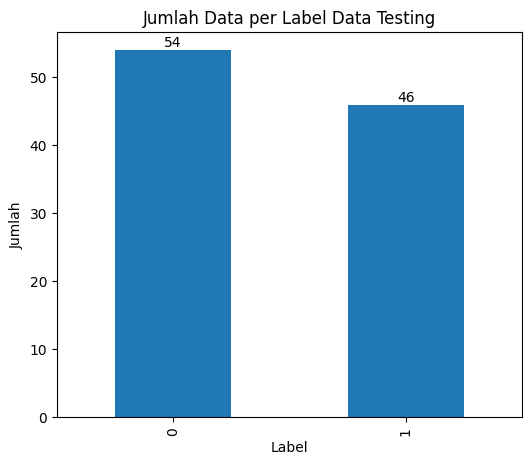

In [20]:
# Hitung jumlah per label
counts = y_test.value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(6,5))
counts.plot(kind='bar')

# Tambahkan judul dan label sumbu
plt.title('Jumlah Data per Label Data Testing')
plt.xlabel('Label')
plt.ylabel('Jumlah')

# Tambahkan nilai pada setiap batang
for i, v in enumerate(counts):
    plt.text(i, v + (0.01 * v), str(v), ha='center')

plt.show()

## SMOTE

In [21]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

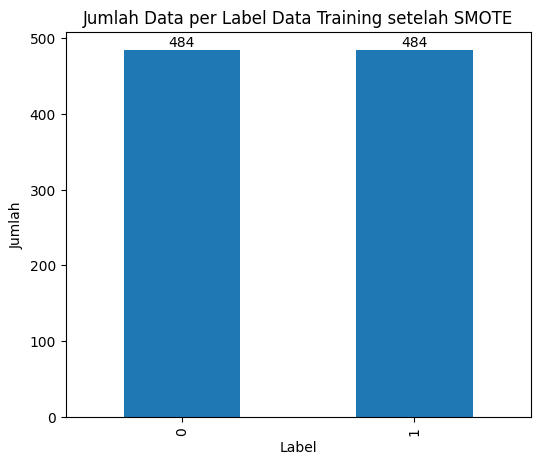

In [22]:
# Hitung jumlah per label
counts = y_train_smote.value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(6,5))
counts.plot(kind='bar')

# Tambahkan judul dan label sumbu
plt.title('Jumlah Data per Label Data Training setelah SMOTE')
plt.xlabel('Label')
plt.ylabel('Jumlah')

# Tambahkan nilai pada setiap batang
for i, v in enumerate(counts):
    plt.text(i, v + (0.01 * v), str(v), ha='center')

plt.show()

## Random Forest

In [23]:
# model = RandomForestClassifier(random_state=42)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=20,
    random_state=42,
)

model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)

In [24]:
joblib.dump(model, "random_forest_model.pkl")
print('Model berhasil disimpan.')

Model berhasil disimpan.


In [25]:
# Hitung metrik evaluasi
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Accuracy : {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall   : {:.2f}%'.format(recall * 100))
print('F1 Score : {:.2f}%'.format(f1 * 100))

Accuracy : 94.00%
Precision: 94.00%
Recall   : 94.00%
F1 Score : 94.00%


In [26]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9444    0.9444    0.9444        54
           1     0.9348    0.9348    0.9348        46

    accuracy                         0.9400       100
   macro avg     0.9396    0.9396    0.9396       100
weighted avg     0.9400    0.9400    0.9400       100



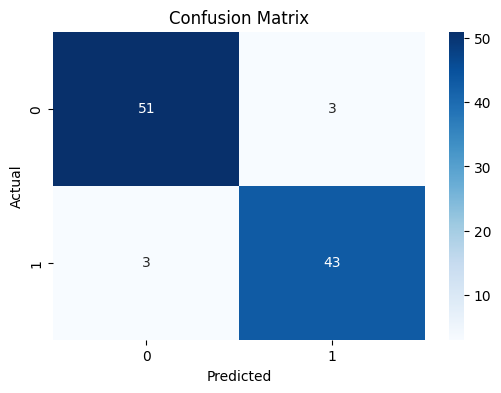

In [27]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()